# Coughvid data set used for categorizing cough as covid+ or healthy

Importing libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import subprocess
from pathlib import Path

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Flatten
from tensorflow.nn import local_response_normalization
from keras.preprocessing.sequence import pad_sequences

In [ ]:
import matplotlib.pyplot as plt
import librosa
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter,filtfilt
from scipy.stats import kurtosis
import scipy.signal as signal
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter,filtfilt
from scipy.signal import cwt
from scipy.signal import hilbert
from scipy.signal import resample
from scipy.signal import decimate
from scipy.signal import spectrogram
from scipy.signal.windows import get_window
import os
import sys

# Cleaning Data
converting .webm and.ogg to .wav files

In [ ]:
def convert_files(folder):
    """Convert files from .webm and .ogg to .wav
    folder: path to coughvid database and metadata_compiled csv"""
    
    df = pd.read_csv(folder + 'metadata_compiled.csv')
    names_to_convert = df.uuid.to_numpy()
    for counter, name in enumerate(names_to_convert):
        if (counter%1000 == 0):
            print("Finished {0}/{1}".format(counter,len(names_to_convert)))
        if os.path.isfile(folder + name + '.webm'):
            subprocess.call(["ffmpeg", "-i", folder+name+".webm", folder+name+".wav"])
        elif os.path.isfile(folder + name + '.ogg'):
            subprocess.call(["ffmpeg", "-i", folder+name+".ogg", folder+name+".wav"])
        else:
            print("Error: No file name {0}".format(name))

In [ ]:
convert_files("./public_dataset/")

Finished 0/27550
Finished 1000/27550
Finished 2000/27550
Finished 3000/27550
Finished 4000/27550
Finished 5000/27550
Finished 6000/27550
Finished 7000/27550
Finished 8000/27550
Finished 9000/27550
Finished 10000/27550
Finished 11000/27550
Finished 12000/27550
Finished 13000/27550
Finished 14000/27550
Finished 15000/27550
Finished 16000/27550
Finished 17000/27550
Finished 18000/27550
Finished 19000/27550
Finished 20000/27550
Finished 21000/27550
Finished 22000/27550
Finished 23000/27550
Finished 24000/27550
Finished 25000/27550
Finished 26000/27550
Finished 27000/27550


In [ ]:
df = pd.read_csv("./public_dataset/metadata_compiled.csv")

In [ ]:
coughvid_dataset = df

In [ ]:
coughvid_dataset.head()

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,7.326171,48.9,2.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,male,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0012c608-33d0-4ef7-bde3-75a0b1a0024e,2020-04-15T01:03:59.029326+00:00,0.0482,0.000000,-16.5,-71.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
coughvid_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   27550 non-null  object 
 1   datetime               27550 non-null  object 
 2   cough_detected         27550 non-null  float64
 3   SNR                    27550 non-null  float64
 4   latitude               16084 non-null  float64
 5   longitude              16084 non-null  float64
 6   age                    15218 non-null  float64
 7   gender                 16224 non-null  object 
 8   respiratory_condition  16224 non-null  object 
 9   fever_muscle_pain      16224 non-null  object 
 10  status                 16224 non-null  object 
 11  quality_1              820 non-null    object 
 12  cough_type_1           802 non-null    object 
 13  dyspnea_1              820 non-null    object 
 14  wheezing_1             820 non-null    object 
 15  st

In [ ]:
coughvid_dataset["status"].unique()

array([nan, 'healthy', 'COVID-19', 'symptomatic'], dtype=object)

labeling Nan data using dignosis 1/2/3/4 columns

In [ ]:
for idx in coughvid_dataset.index:
    if ((pd.isnull(coughvid_dataset["status"][idx]) or coughvid_dataset["status"][idx] == "healthy") 
    and (coughvid_dataset["diagnosis_1"][idx] == "COVID-19" 
         or coughvid_dataset["diagnosis_2"][idx] == "COVID-19"
        or coughvid_dataset["diagnosis_3"][idx] == "COVID-19"
        or coughvid_dataset["diagnosis_4"][idx] == "COVID-19")) or coughvid_dataset["status"][idx] == 'symptomatic':
        coughvid_dataset["status"][idx] = "COVID_19"
        

<ipython-input-9-afaa66e0f316>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coughvid_dataset["status"][idx] = "COVID_19"


In [ ]:
coughvid_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   27550 non-null  object 
 1   datetime               27550 non-null  object 
 2   cough_detected         27550 non-null  float64
 3   SNR                    27550 non-null  float64
 4   latitude               16084 non-null  float64
 5   longitude              16084 non-null  float64
 6   age                    15218 non-null  float64
 7   gender                 16224 non-null  object 
 8   respiratory_condition  16224 non-null  object 
 9   fever_muscle_pain      16224 non-null  object 
 10  status                 16300 non-null  object 
 11  quality_1              820 non-null    object 
 12  cough_type_1           802 non-null    object 
 13  dyspnea_1              820 non-null    object 
 14  wheezing_1             820 non-null    object 
 15  st

forming a second dataset using the columns

In [ ]:
coughvid = coughvid_dataset[["uuid", "status"]]

In [ ]:
coughvid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   uuid    27550 non-null  object
 1   status  16300 non-null  object
dtypes: object(2)
memory usage: 430.6+ KB


In [ ]:
coughvid.dropna(inplace= True)

<ipython-input-13-f4fe728b3639>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coughvid.dropna(inplace= True)


In [ ]:
coughvid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16300 entries, 1 to 27548
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   uuid    16300 non-null  object
 1   status  16300 non-null  object
dtypes: object(2)
memory usage: 382.0+ KB


removing the uuid not present in the data folder

In [ ]:
for uuid in coughvid["uuid"]:
    if os.path.isfile("./public_dataset/" + uuid + ".wav") == False:
        coughvid.drop(coughvid[coughvid['uuid'] == uuid].index, inplace = True)
    

In [ ]:
coughvid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16300 entries, 1 to 27548
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   uuid    16300 non-null  object
 1   status  16300 non-null  object
dtypes: object(2)
memory usage: 382.0+ KB


# Segmenting the data

In [ ]:
def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

In [ ]:
coughvid_sgmntd = pd.DataFrame(columns = ["status", "fs", "data"])

In [ ]:
coughvid_sgmntd

,status,fs,data


Text(0.5, 1.0, 'Input cough signal')

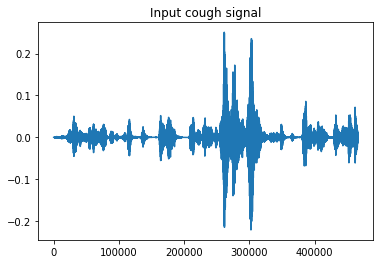

In [ ]:
file = "./public_dataset/001d8e33-a4af-4edb-98ba-b03f891d9a6c.wav"
x,fs = librosa.load(file, sr=None)
plt.plot(x)
plt.title("Input cough signal")

Text(0.5, 1.0, 'Segmentation Output')

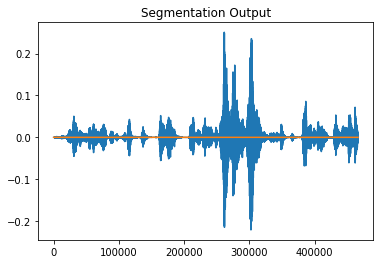

In [ ]:
cough_segments, cough_mask = segment_cough(x,fs,cough_padding=0)
plt.plot(x)
plt.plot(cough_mask)
plt.title("Segmentation Output")

In [ ]:
if len(cough_segments) != 0:
    fig, axs = plt.subplots(len(cough_segments),1, figsize=(7,10))
    for i in range(0,len(cough_segments)):
        axs[i].plot(cough_segments[i])
        axs[i].set_title("Cough segment " + str(i))

In [ ]:
coughvid.reset_index(drop = True, inplace = True)

# Adding segmented data to further increase the no of samples?

In [ ]:
for idx in coughvid["uuid"].index:
    if (idx%1000 == 0 or idx <10):
        print("Finished {0}/{1}".format(idx,len(coughvid["uuid"])), coughvid_sgmntd.shape)
    file = "./public_dataset/"+ coughvid["uuid"][idx] +".wav"
    x,fs = librosa.load(file, sr=None)
    cough_segments, cough_mask = segment_cough(x,fs,cough_padding=0)
    if len(cough_segments) != 0:
        for i in range(0,len(cough_segments)):
            coughvid_sgmntd = coughvid_sgmntd.append({"data":cough_segments[i], "status":coughvid["status"][idx], "fs":fs}, ignore_index = True)
        

Finished 0/16300 (0, 3)
Finished 1/16300 (2, 3)
Finished 2/16300 (2, 3)
Finished 3/16300 (6, 3)
Finished 4/16300 (10, 3)
Finished 5/16300 (10, 3)
Finished 6/16300 (11, 3)
Finished 7/16300 (14, 3)
Finished 8/16300 (19, 3)
Finished 9/16300 (21, 3)
Finished 1000/16300 (2114, 3)
Finished 2000/16300 (4363, 3)
Finished 3000/16300 (6469, 3)
Finished 4000/16300 (8646, 3)
Finished 5000/16300 (10859, 3)
Finished 6000/16300 (13125, 3)
Finished 7000/16300 (15351, 3)
Finished 8000/16300 (17647, 3)
Finished 9000/16300 (19866, 3)
Finished 10000/16300 (22102, 3)
Finished 11000/16300 (24344, 3)
Finished 12000/16300 (26600, 3)
Finished 13000/16300 (28731, 3)
Finished 14000/16300 (30940, 3)
Finished 15000/16300 (33138, 3)
Finished 16000/16300 (35396, 3)


In [ ]:
coughvid_sgmntd.to_csv("segmented.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pickle5
import pickle5 as pickle
coughvid_sgmntd = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Data/segmented.pkl", "rb"))

In [ ]:
coughvid_sgmntd["status"].unique()

array(['healthy', 'COVID_19', 'COVID-19'], dtype=object)

In [ ]:
for idx in coughvid_sgmntd.index:
    if coughvid_sgmntd["status"][idx] == "COVID_19" or coughvid_sgmntd["status"][idx] == "COVID-19":
        coughvid_sgmntd["status"][idx] = 1
    else:
        coughvid_sgmntd["status"][idx] = 0 

In [ ]:
coughvid_sgmntd["status"].unique()

array([0, 1], dtype=object)

In [ ]:
max_len = 0
for data in coughvid_sgmntd["data"]:
    if len(data) > max_len:
        max_len = len(data)
max_len

307310

# calculating the MFCC

In [ ]:
def MFCC(data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of MFCC coefficient
        names = []; names_mean = []; names_std = []
        fs, cough = data
        n_mfcc = 13
        for i in range(n_mfcc):
            names_mean = names_mean + ['MFCC_mean'+str(i)]
            names_std = names_std +  ['MFCC_std'+str(i)]
        names = names_mean + names_std
        mfcc = librosa.feature.mfcc(y = cough, sr = fs, n_mfcc = n_mfcc)
        mfcc_mean = mfcc.mean(axis=1)
        mfcc_std = mfcc.std(axis=1)
        mfcc = np.append(mfcc_mean,mfcc_std)
        return mfcc

Preprocessing the data

In [ ]:
def preprocess_cough(x,fs, cutoff = 6000, normalize = True, filter_ = True, downsample = True):
    """
    Normalize, lowpass filter, and downsample cough samples in a given data folder 
    
    Inputs: x*: (float array) time series cough signal
    fs*: (int) sampling frequency of the cough signal in Hz
    cutoff: (int) cutoff frequency of lowpass filter
    normalize: (bool) normailzation on or off
    filter: (bool) filtering on or off
    downsample: (bool) downsampling on or off
    *: mandatory input
    
    Outputs: x: (float32 array) new preprocessed cough signal
    fs: (int) new sampling frequency
    """
    
    fs_downsample = cutoff*2
    
    #Preprocess Data
    if len(x.shape)>1:
        x = np.mean(x,axis=1)                          # Convert to mono
    if normalize:
        x = x/(np.max(np.abs(x))+1e-17)                # Norm to range between -1 to 1
    if filter_:
        b, a = butter(4, fs_downsample/fs, btype='lowpass') # 4th order butter lowpass filter
        x = filtfilt(b, a, x)
    if downsample:
        x = signal.decimate(x, int(fs/fs_downsample)) # Downsample for anti-aliasing
    
    fs_new = fs_downsample

    return np.float32(x), fs_new

In [ ]:
coughvid_sgmntd_copy = coughvid_sgmntd

# Forming data sets

In [ ]:
x = coughvid_sgmntd["data"]
fs_new = 0
for idx in x.index:
    x[idx], fs_new = preprocess_cough(x[idx], coughvid_sgmntd["fs"][idx])
    data = (fs_new, x[idx])
    mfcc = MFCC(data)
    x[idx] = np.concatenate((x[idx], mfcc))
x = pad_sequences(x, maxlen = 308025)
y = coughvid_sgmntd["status"].astype('int32')
y = y.to_numpy()

In [ ]:
def form_dataset(data, status, test = False):
    data = tf.constant(data)
    status = tf.constant(status)
    if test == False:
        dataset = tf.data.Dataset.from_tensor_slices((data, status))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((data))
    return dataset

In [ ]:
x_train, x_val, x_test = np.split(x,[int(.6*len(x)), int(.8*len(x))])
y_train, y_val, y_test = np.split(y,[int(.6*len(y)), int(.8*len(y))])

In [ ]:
train_dataset = form_dataset(x_train, y_test)
val_dataset = form_dataset(x_val, y_test)
test_dataset = form_dataset(x_test, y_teest, test = True)

# Forming Model

In [ ]:
def cough_classifier(no_samples = 1 ,input_size=308025):

    inputs = Input((1,input_size))
    
    #LSTM
    x = LSTM(input_size, input_shape =(no_samples,1,input_size))(inputs)

    # reshape
    x = Reshape((555, 555))(x)

    #conv1
    x = Conv2D(5, 5, strides = 2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(pool_size=(3, 3))

    #conv2
    x = Conv2D(5, 5, strides = 2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(pool_size=(3, 3))

    #flatten
    x = Flatten()(x)

    #dense
    x = Dense(256)(x)
    x = Dropout(0.3)(x)
    x = Dense(256)(x)
    x = Dropout(0.3)(x)
    x = Dense(1)(x)
    output = Activation('softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model

In [ ]:
model = cough_classifier()
model.summary()

ResourceExhaustedError: ignored

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])